In [ ]:
# for installing pyspark
!pip install pyspark==3.0.0

# mount your google drive to be able to access files from your google drive !
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 16.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044160 sha256=a5be74bdf2b90a7e4eb20df6ab26316cdc3193b083fb26d0919bbf194bc24df8
  Stored in directory: /root/.cache/pip/wheels/b1/bb/8b/ca24d3f756f2ed967225b0871898869db676eb5846df5adc56
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Mounted at /content/drive


In [ ]:
import pyspark

spark = pyspark.sql.SparkSession.builder.appName("Spark-Dataframe-API-Exercises").getOrCreate()

**1: Loading and preping the data**

In [ ]:
# Initialize Spark session
from pyspark.sql import SparkSession



# Load Trump tweets data
tweets_df = spark.read.text("drive/MyDrive/5A IR/TBS/Spark/Donald Trump/trump_tweets.txt")



In [ ]:
# Load positive and negative words lists
positive_words = spark.read.text("drive/MyDrive/5A IR/TBS/Spark/Donald Trump/positive-words.txt").rdd.flatMap(lambda x: x).collect()
negative_words = spark.read.text("drive/MyDrive/5A IR/TBS/Spark/Donald Trump/negative-words.txt").rdd.flatMap(lambda x: x).collect()
stop_words = spark.read.text("drive/MyDrive/5A IR/TBS/Spark/Donald Trump/stop-words.txt").rdd.flatMap(lambda x: x).collect()



In [ ]:
from pyspark.sql.functions import split
# Extract tweet text and date
tweets_df = tweets_df.select(split(tweets_df.value, ";").getItem(0).alias("tweet"),
                             split(tweets_df.value, ";").getItem(1).alias("date"))


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Defining a function to remove links from tweets
def remove_links(tweet):
    import re
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '', tweet)

# Defining the UDF for removing links
remove_links_udf = udf(remove_links, StringType())

# Filtering out retweets
tweets_df = tweets_df.filter(~tweets_df.tweet.startswith("RT"))

# Applying the UDF to remove links from tweets
tweets_df = tweets_df.withColumn("tweet", remove_links_udf(tweets_df["tweet"]))


In [ ]:
tweets_df.show(5)

+--------------------+-------------------+
|               tweet|               date|
+--------------------+-------------------+
|Republicans and D...|02/08/2011 18:07:48|
|I was thrilled to...|03/03/2020 01:34:50|
|The Unsolicited M...|12/09/2020 20:10:58|
|“I’m running as a...|12/10/2020 22:22:39|
|Getting a little ...|01/02/2020 16:14:02|
+--------------------+-------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import to_timestamp, date_format

# Convertir la colonne "date" en format de date et d'heure
tweets_df = tweets_df.withColumn("date", to_timestamp("date", "dd/MM/yyyy HH:mm:ss"))

# creer la colonne year_month
tweets_df = tweets_df.withColumn("year_month", date_format("date", "yyyy-MM"))

tweets_df.show(5)


+--------------------+-------------------+----------+
|               tweet|               date|year_month|
+--------------------+-------------------+----------+
|Republicans and D...|2011-08-02 18:07:48|   2011-08|
|I was thrilled to...|2020-03-03 01:34:50|   2020-03|
|The Unsolicited M...|2020-09-12 20:10:58|   2020-09|
|“I’m running as a...|2020-10-12 22:22:39|   2020-10|
|Getting a little ...|2020-02-01 16:14:02|   2020-02|
+--------------------+-------------------+----------+
only showing top 5 rows



**2 : Sentiment Analysis Over time**


In [ ]:

from pyspark.sql.functions import split, lower


In [ ]:
from pyspark.sql.functions import lower, udf, explode
from pyspark.sql.types import ArrayType, IntegerType

# function to count positive and negative words
def count_sentiment_words(tweet):
    words = [word for word in tweet.split() if word not in stop_words]
    pos_count = sum(word in positive_words for word in words)
    neg_count = sum(word in negative_words for word in words)
    return [pos_count, neg_count]


count_sentiment_udf = udf(count_sentiment_words, ArrayType(IntegerType()))

# Counting positive and negative words in each tweet
tweets_df = tweets_df.withColumn("pos_neg_counts", count_sentiment_udf(lower(tweets_df["tweet"])))


In [ ]:
# Exploding the pos_neg_counts array column
tweets_df = tweets_df.select("tweet", "date", "year_month",
                             tweets_df.pos_neg_counts[0].alias("pos_count"),
                             tweets_df.pos_neg_counts[1].alias("neg_count"))

In [ ]:
from pyspark.sql.functions import col

# Filtering out rows with null values in the year_month column
tweets_df_filtered = tweets_df.filter(col("year_month").isNotNull())

# Aggregating sentiment counts by year-month
sentiment_counts = tweets_df_filtered.groupBy("year_month").sum("pos_count", "neg_count").orderBy("year_month")


sentiment_counts.show(5)

+----------+--------------+--------------+
|year_month|sum(pos_count)|sum(neg_count)|
+----------+--------------+--------------+
|   2009-05|            26|             3|
|   2009-06|            11|             2|
|   2009-07|             9|             0|
|   2009-08|             5|             2|
|   2009-09|             3|             1|
+----------+--------------+--------------+
only showing top 5 rows



In [ ]:
#i wanted to try out ploting this without converting so i needed the type
type(sentiment_counts)

pyspark.sql.dataframe.DataFrame

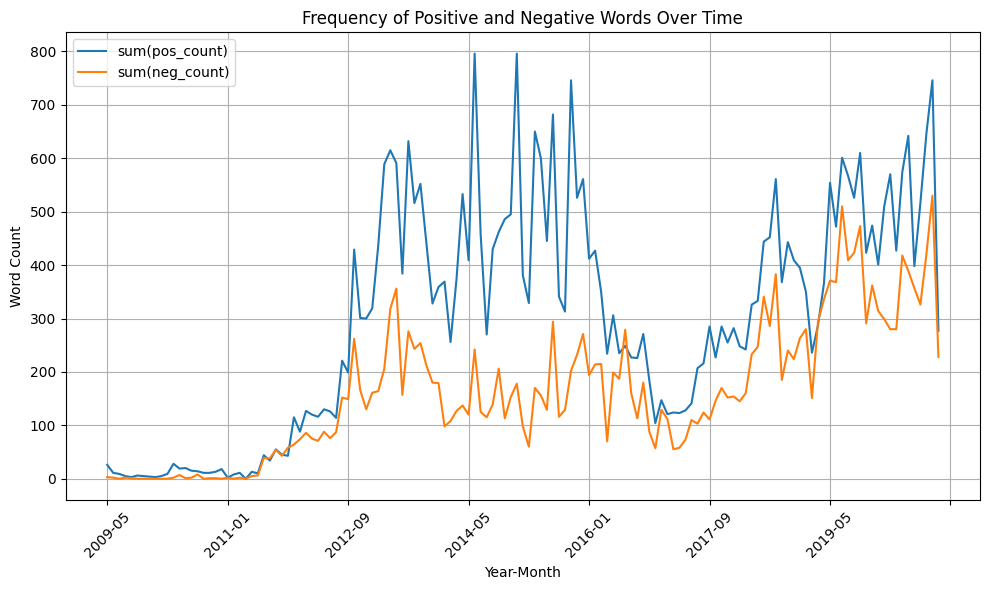

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plotting positive and negative word counts over time
sentiment_counts.select("year_month", "sum(pos_count)", "sum(neg_count)") \
    .toPandas() \
    .plot(x="year_month", figsize=(10, 6))
plt.xlabel("Year-Month")
plt.ylabel("Word Count")
plt.title("Frequency of Positive and Negative Words Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




*   Key 1 : Throughout the period spanning from 2009 to 2020, the cumulative count of
negative words consistently remains lower than the cumulative count of positive words.


* Key 2 : We see a decline in positive tweets ( and
tweets in general) at the surrounding the begining of 2016, this could be due to either one of these reasons :
1. Donald Trump was not tweeting as much as before since he was preparing his presidential compaign.
2. Donald Trump was spreading his racist thoughts so it was interpreted as negative (as it should).  







**3 : Top Hashtags and references**

In [ ]:
from pyspark.sql.types import StructType, StructField, ArrayType, StringType

#  function to extract hashtags and references while filtering out stop words
def extract_hashtags_and_references(tweet):
    words = [word for word in tweet.split() if word.lower() not in stop_words]
    hashtags = [word.lower() for word in words if word.startswith("#")]
    references = [word.lower() for word in words if word.startswith("@")]
    return hashtags, references

#  the return type for the UDF
return_type = StructType([
    StructField("hashtags", ArrayType(StringType(), True)),
    StructField("references", ArrayType(StringType(), True))
])

# Registering the UDF with the correct return type
extract_hashtags_and_references_udf = udf(extract_hashtags_and_references, return_type)

# Extracting hashtags and references while filtering out stop words
hashtags_references_df = tweets_df.withColumn("hashtags_and_references", extract_hashtags_and_references_udf(lower(tweets_df["tweet"])))

# Exploding the hashtags and references array columns
hashtags_df = hashtags_references_df.select(explode("hashtags_and_references.hashtags").alias("hashtag")).groupBy("hashtag").count().orderBy("count", ascending=False)
references_df = hashtags_references_df.select(explode("hashtags_and_references.references").alias("reference")).groupBy("reference").count().orderBy("count", ascending=False)


In [ ]:
# Loading stop words from file
stop_words = spark.read.text("drive/MyDrive/5A IR/TBS/Spark/Donald Trump/stop-words.txt").rdd.map(lambda row: row.value.lower()).collect()





In [ ]:
from pyspark.sql.functions import lower, explode
from pyspark.sql.types import ArrayType, StringType

# Defining the UDF to extract hashtags
def extract_hashtags(tweet):
    stop_words_set = set(stop_words)  # Convert stop_words to a set for faster lookup
    words = [word for word in tweet.split() if word.lower() not in stop_words_set]
    hashtags = [word.lower().strip('#[]""') for word in words if word.startswith("#")]
    return hashtags

# Registering the UDF with the correct return type
return_type = ArrayType(StringType(), True)
extract_hashtags_udf = udf(extract_hashtags, return_type)

# Applying the UDF to extract hashtags
hashtags_df = tweets_df.withColumn("hashtags", explode(extract_hashtags_udf(lower(tweets_df["tweet"])))).groupBy("hashtags").count().orderBy("count", ascending=False)


In [ ]:
# Convert Spark DataFrames to Pandas DataFrames for visualization
hashtags_pd = hashtags_df.limit(10).toPandas()
#references_pd = references_df.limit(10).toPandas()

In [ ]:
print(hashtags_pd.columns)

Index(['hashtags', 'count'], dtype='object')


In [ ]:
#doing this to solve errors and see why it doen't wanna work
print("First few rows of hashtags_pd DataFrame:")
print(hashtags_pd.head(10))

print("\nFirst few rows of references_pd DataFrame:")
#print(references_pd.head())

First few rows of hashtags_pd DataFrame:
                hashtags  count
0              trump2016    818
1  makeamericagreatagain    387
2                   maga    376
3        celebapprentice    282
4    celebrityapprentice    132
5                      1    112
6                  trump    107
7         timetogettough     81
8              votetrump     72
9      trumpforpresident     71

First few rows of references_pd DataFrame:


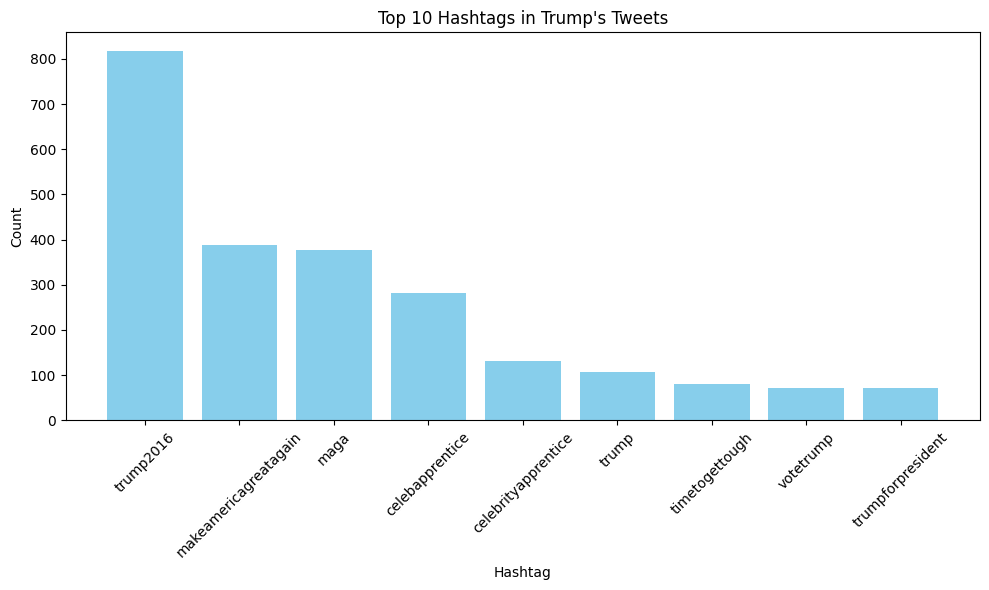

In [ ]:
# Filter out singular numbers from the hashtags
hashtags_pd_filtered = hashtags_pd[~hashtags_pd['hashtags'].str.match(r'^\d$')]

# Plotting top hashtags
plt.figure(figsize=(10, 6))
plt.bar(hashtags_pd_filtered["hashtags"], hashtags_pd_filtered["count"], color="skyblue")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.title("Top 10 Hashtags in Trump's Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Key 3 : As we see the top hashtags refer to his presidential compaign in 2016.

**4 : Word cloud of most used words**

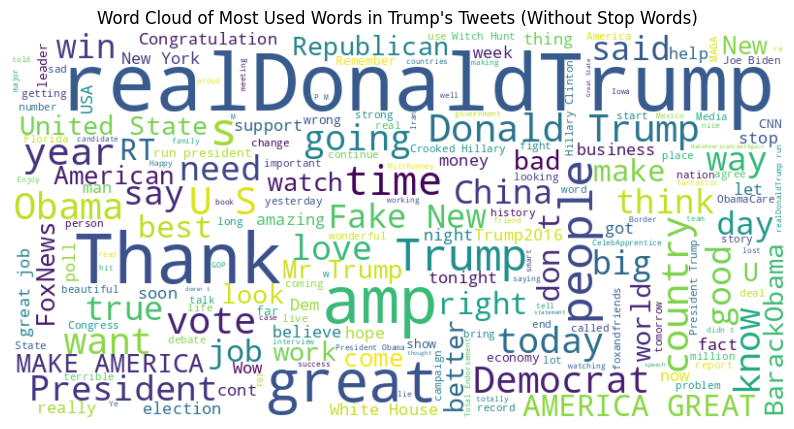

In [ ]:
from wordcloud import WordCloud

# Extracting all words from tweets
all_words = tweets_df.select(explode(split(tweets_df.tweet, " ")).alias("word")).rdd.map(lambda x: x[0]).collect()

# Filtering out stop words
all_words_filtered = [word for word in all_words if word.lower() not in stop_words]

# Creating a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words_filtered))

# Displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Used Words in Trump's Tweets (Without Stop Words)")
plt.show()


Key 4 : We clearly notice a pattern in here relating to the presendential compaign held in 2016. So we see a lot of "vote"; "great" "america" "white house" etc..

**5: Tweet volume over time**

In [ ]:
# Show the DataFrame to inspect the data
tweets_df.show()



+--------------------+-------------------+----------+---------+---------+
|               tweet|               date|year_month|pos_count|neg_count|
+--------------------+-------------------+----------+---------+---------+
|Republicans and D...|2011-08-02 18:07:48|   2011-08|        0|        0|
|I was thrilled to...|2020-03-03 01:34:50|   2020-03|        7|        0|
|The Unsolicited M...|2020-09-12 20:10:58|   2020-09|        0|        2|
|“I’m running as a...|2020-10-12 22:22:39|   2020-10|        2|        0|
|Getting a little ...|2020-02-01 16:14:02|   2020-02|        0|        0|
|                    |2020-10-23 04:52:14|   2020-10|        0|        0|
|                    |2020-10-23 04:46:53|   2020-10|        0|        0|
|                    |2020-10-23 04:46:49|   2020-10|        0|        0|
|                    |2020-10-23 04:46:45|   2020-10|        0|        0|
|         Unemploym…"|2020-03-08 04:01:46|   2020-03|        0|        0|
|   Thank you Elise! |2020-01-09 12:24

In [ ]:
# Filtering out null values in the 'year_month' column
tweets_df = tweets_df.filter(tweets_df["year_month"].isNotNull())

tweets_df.show()



+--------------------+-------------------+----------+---------+---------+
|               tweet|               date|year_month|pos_count|neg_count|
+--------------------+-------------------+----------+---------+---------+
|Republicans and D...|2011-08-02 18:07:48|   2011-08|        0|        0|
|I was thrilled to...|2020-03-03 01:34:50|   2020-03|        7|        0|
|The Unsolicited M...|2020-09-12 20:10:58|   2020-09|        0|        2|
|“I’m running as a...|2020-10-12 22:22:39|   2020-10|        2|        0|
|Getting a little ...|2020-02-01 16:14:02|   2020-02|        0|        0|
|                    |2020-10-23 04:52:14|   2020-10|        0|        0|
|                    |2020-10-23 04:46:53|   2020-10|        0|        0|
|                    |2020-10-23 04:46:49|   2020-10|        0|        0|
|                    |2020-10-23 04:46:45|   2020-10|        0|        0|
|         Unemploym…"|2020-03-08 04:01:46|   2020-03|        0|        0|
|   Thank you Elise! |2020-01-09 12:24

In [ ]:
tweet_volume_pd.head()


,year_month,count
0,None,6334
1,2009-05,42
2,2009-06,22
3,2009-07,10
4,2009-08,14


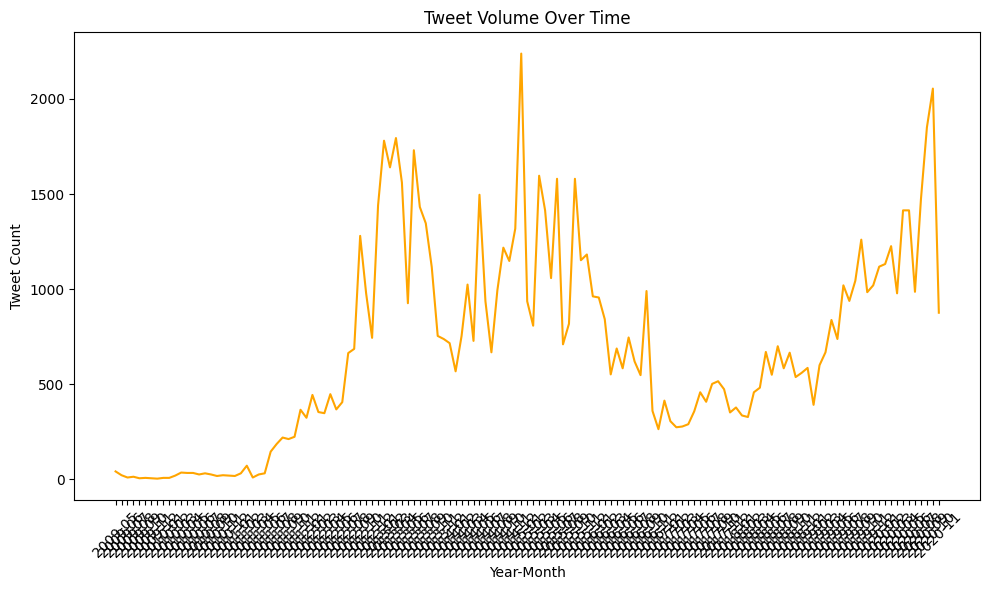

In [ ]:
# Filtering out rows with None values in the 'year_month' column
tweet_volume_pd_filtered = tweet_volume_pd.dropna(subset=['year_month'])

# Plotting tweet volume over time
plt.figure(figsize=(10, 6))
plt.plot(tweet_volume_pd_filtered["year_month"], tweet_volume_pd_filtered["count"], color="orange")
plt.xlabel("Year-Month")
plt.ylabel("Tweet Count")
plt.title("Tweet Volume Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


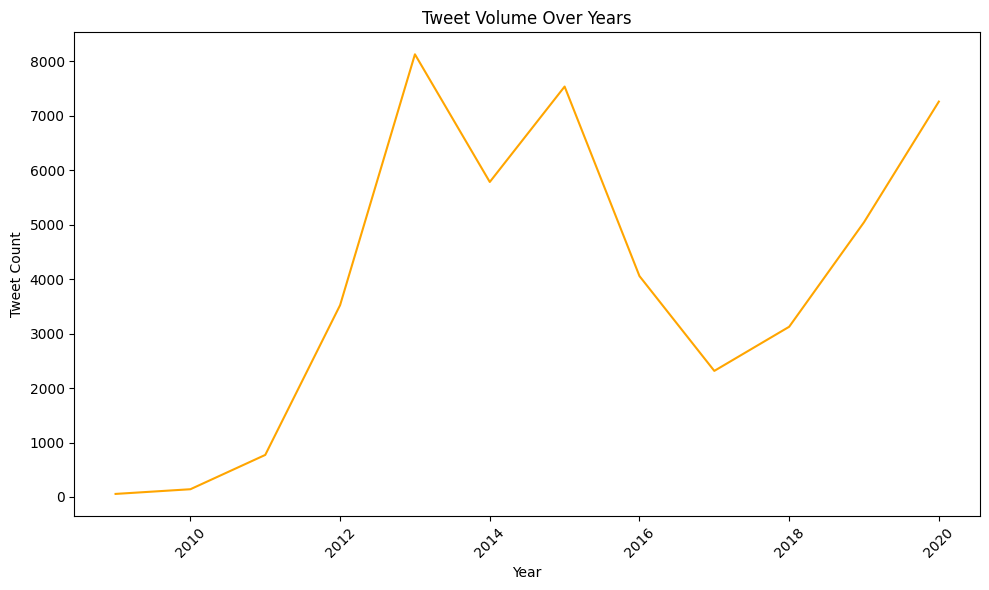

In [ ]:
from pyspark.sql.functions import year

# Transforming the date column into a year column
tweets_df = tweets_df.withColumn("year", year("date"))

# Aggregating tweet counts by year
tweet_volume_yearly = tweets_df.groupBy("year").count().orderBy("year")

# Collecting data from tweet_volume_yearly DataFrame
years = [row['year'] for row in tweet_volume_yearly.collect()]
counts = [row['count'] for row in tweet_volume_yearly.collect()]

# Plotting tweet volume over years
plt.figure(figsize=(10, 6))
plt.plot(years, counts, color="orange")
plt.xlabel("Year")
plt.ylabel("Tweet Count")
plt.title("Tweet Volume Over Years")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Key 5 : This confirms a hypothesis that we have made earlier. indeed surrounding the Presidential compaign Donald Trump was posting less so we have a decrease in the volume of tweets.

**Bonus**

In [ ]:
!pip install sparknlp==3.3.1

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *


ERROR: Could not find a version that satisfies the requirement sparknlp==3.2.3 (from versions: 0.0.1, 1.0.0)
ERROR: No matching distribution found for sparknlp==3.2.3
